In [65]:
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import BSpline, make_interp_spline
import os

# 定义解析日志文件的函数
def parse_log_file(file_path, output_num, start_line):
    epochs = []
    mae_values = []
    current_epoch = None
    
    with open(file_path, 'r') as file:
        # 跳过前 start_line 行
        for _ in range(start_line):
            next(file)
        
        for line in file:
            # 匹配 epoch
            epoch_match = re.search(r'Epoch \[(\d+)/\d+\]', line)
            if epoch_match:
                current_epoch = int(epoch_match.group(1))
            
            # 匹配 MAE 值
            mae_match = re.search(rf'Output {output_num} - .* MAE: ([\d.]+)', line)
            if mae_match and current_epoch is not None:
                mae = float(mae_match.group(1))
                epochs.append(current_epoch)
                mae_values.append(mae)
    
    return epochs, mae_values

# 定义截断 epochs 和 mae 的函数
def truncate_epochs_and_mae(epochs, mae, max_epoch):
    truncated_epochs = []
    truncated_mae = []
    for epoch, value in zip(epochs, mae):
        if epoch <= max_epoch:
            truncated_epochs.append(epoch)
            truncated_mae.append(value)
    return truncated_epochs, truncated_mae

# 定义绘制曲线的函数
def plot_mae_curves(epochs1, mae1, epochs_best, mae_best, origin_name, task_name, selected_mae):
    # 确定最大 epoch 值
    max_epoch = min(max(epochs_best), 300)  # 直接使用 epochs_best 的最大值
    
    # 截断 epochs 和 mae
    epochs1, mae1 = truncate_epochs_and_mae(epochs1, mae1, max_epoch)
    epochs_best, mae_best = truncate_epochs_and_mae(epochs_best, mae_best, max_epoch)
    
    # 调整图的大小
    plt.figure(figsize=(16, 12))
    
    # 绘制折线图
    plt.plot(epochs1, mae1, 'o-', color='#1f77b4', label=origin_name, markersize=5, linewidth=3, alpha=0.8)
    plt.plot(epochs_best, mae_best, 'o-', color='#ff7f0e', label=f'MEvoN-MPP$_{{\\mathrm{{{origin_name}}}}}$', markersize=5, linewidth=3, alpha=0.8)
    
    # 使用 B样条拟合曲线
    if len(epochs1) > 3:  # 确保有足够的数据点进行插值
        # 创建 B样条曲线
        t1 = np.linspace(0, 1, len(epochs1))  # 参数化
        spl1 = make_interp_spline(t1, mae1, k=2)  # 使用二次 B样条 (k=2)
        t_new1 = np.linspace(0, 1, 300)  # 新的参数化区间
        y_new1 = spl1(t_new1)
        plt.plot(np.linspace(min(epochs1), max(epochs1), 300), y_new1, '-', color='#aec7e8', linewidth=30, alpha=0.6)
    
    if len(epochs_best) > 3:
        # 创建 B样条曲线
        t_best = np.linspace(0, 1, len(epochs_best))  # 参数化
        spl_best = make_interp_spline(t_best, mae_best, k=2)  # 使用二次 B样条 (k=2)
        t_new_best = np.linspace(0, 1, 300)  # 新的参数化区间
        y_new_best = spl_best(t_new_best)
        plt.plot(np.linspace(min(epochs_best), max(epochs_best), 300), y_new_best, '-', color='#ffbb78', linewidth=30, alpha=0.6)
    
    # 设置坐标轴标签和字体大小
    plt.xlabel('Epoch', fontsize=50)
    plt.ylabel('MAE', fontsize=50)
    
    # 设置刻度字体大小
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    
    # 设置图例字体大小
    plt.legend(loc='upper right', fontsize=40)
    
    plt.grid(False)  # 关闭网格
    plt.tight_layout()  # 自动调整子图间距

    # 创建保存目录
    save_dir = os.path.join('imgs', origin_name)
    os.makedirs(save_dir, exist_ok=True)

    # 保存 PDF 文件
    save_path = os.path.join(save_dir, f'{task_name}_{selected_mae}.pdf')
    plt.savefig(save_path, dpi=500, format='pdf', bbox_inches='tight')
    plt.close()  # 关闭图形，避免重复显示
    print(f"保存文件到 {save_path}")

# 文件路径
# schnet
# file1 = '/home/data1/lk/project/mol_tree/logs/schnet/homo/only_schnet_qm9_homo_training_log_20250112_111521.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/schnet/homo/schnet_qm9_homo_training_log_20250111_170354.log'
# file1 = '/home/data1/lk/project/mol_tree/logs/schnet/lumo/only_schnet_qm9_lumo_training_log_20250112_111524.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/schnet/lumo/schnet_qm9_lumo_training_log_20250111_172230.log'
# file1 = '/home/data1/lk/project/mol_tree/logs/schnet/gap/only_schnet_qm9_gap_training_log_20250112_111527.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/schnet/gap/schnet_qm9_gap_training_log_20250111_170358.log'
# comenet
# file1 = '/home/data1/lk/project/mol_tree/logs/comenet/homo/only_comenet_qm9_homo_training_log_20250116_005730.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/comenet/homo/comenet_qm9_homo_training_log_20250115_194531.log'
# file1 = '/home/data1/lk/project/mol_tree/logs/comenet/lumo/only_comenet_qm9_lumo_training_log_20250116_104836.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/comenet/lumo/comenet_qm9_lumo_training_log_20250117_094453.log'
# file1 = '/home/data1/lk/project/mol_tree/logs/comenet/gap/only_comenet_qm9_gap_training_log_20250116_104811.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/comenet/gap/comenet_qm9_gap_training_log_20250116_093412.log'
# gin
# file1 = '/home/data1/lk/project/mol_tree/logs/only_gin_qm9_homo_training_log_20250111_060843.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/gin_qm9_homo_training_log_20250111_045946.log'
# file1 = '/home/data1/lk/project/mol_tree/logs/only_gin_qm9_lumo_training_log_20250111_060856.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/gin_qm9_lumo_training_log_20250112_040119.log'
# file1 = '/home/data1/lk/project/mol_tree/logs/only_gin_qm9_gap_training_log_20250111_060356.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/gin_qm9_gap_training_log_20250111_045954.log'
# gcn
# file1 = '/home/data1/lk/project/mol_tree/logs/only_gcn_qm9_homo_training_log_20250114_054337.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/qm9_homo_training_log_20241214_231603.log'
# file1 = '/home/data1/lk/project/mol_tree/logs/only_gcn_qm9_lumo_training_log_20250114_054440.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/qm9_lumo_training_log_20241212_004645.log'
file1 = '/home/data1/lk/project/mol_tree/logs/only_gcn_qm9_gap_training_log_20241226_072658.log'
file2 = '/home/data1/lk/project/mol_tree/logs/qm9_gap_training_log_20241220_034325.log'

# 提取 origin_name（夹在 only 和 qm9 之间的部分）
origin_name = file1.split('/')[-1].split('only_')[-1].split('_qm9')[0]
if origin_name == 'schnet':
    origin_name = 'SchNet'
elif origin_name == 'comenet':
    origin_name = 'ComENet'
elif origin_name == 'gin':
    origin_name = 'GIN'
elif origin_name == 'gcn':
    origin_name = 'GCN'
else:
    raise ValueError('Unknown origin name')

# 根据 origin_name 设置 start_line
start_line_dict = {
    'SchNet': 2300,
    'ComENet': 2300,
    'GIN': 1800,
    'GCN': 1200
}
start_line = start_line_dict.get(origin_name, 0)  # 默认值为 0

# 解析日志文件
epochs1, mae1 = parse_log_file(file1, 1, start_line)
epochs2, mae2 = parse_log_file(file2, 2, start_line)
epochs3, mae3 = parse_log_file(file2, 3, start_line)

# 比较 mae2 和 mae3 的平均值，选择较优的
mae2_avg = np.mean(mae2) if mae2 else float('inf')
mae3_avg = np.mean(mae3) if mae3 else float('inf')

if mae2_avg < mae3_avg:
    print("选择的是 mae2")
    selected_mae = 'mae2'
    epochs_best, mae_best = epochs2, mae2
else:
    print("选择的是 mae3")
    selected_mae = 'mae3'
    epochs_best, mae_best = epochs3, mae3

# 提取任务名称（如 homo）
task_name = file1.split('/')[-1].split('qm9_')[-1].split('_training')[0]

# 绘制MAE曲线并保存为 PDF
plot_mae_curves(epochs1, mae1, epochs_best, mae_best, origin_name, task_name, selected_mae)

选择的是 mae3
保存文件到 imgs/GCN/gap_mae3.pdf


In [58]:
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import BSpline, make_interp_spline
import os

# 定义解析日志文件的函数
# def parse_log_file(file_path, output_num, start_line=2300):
# gin
# def parse_log_file(file_path, output_num, start_line=1800):
# gcn
def parse_log_file(file_path, output_num, start_line=1200):
    epochs = []
    mae_values = []
    current_epoch = None
    
    with open(file_path, 'r') as file:
        # 跳过前 start_line 行
        for _ in range(start_line):
            next(file)
        
        for line in file:
            # 匹配 epoch
            epoch_match = re.search(r'Epoch \[(\d+)/\d+\]', line)
            if epoch_match:
                current_epoch = int(epoch_match.group(1))
            
            # 匹配 MAE 值
            mae_match = re.search(rf'Output {output_num} - .* MAE: ([\d.]+)', line)
            if mae_match and current_epoch is not None:
                mae = float(mae_match.group(1))
                epochs.append(current_epoch)
                mae_values.append(mae)
    
    return epochs, mae_values

# 定义截断 epochs 和 mae 的函数
def truncate_epochs_and_mae(epochs, mae, max_epoch):
    truncated_epochs = []
    truncated_mae = []
    for epoch, value in zip(epochs, mae):
        if epoch <= max_epoch:
            truncated_epochs.append(epoch)
            truncated_mae.append(value)
    return truncated_epochs, truncated_mae

# 定义绘制曲线的函数
def plot_mae_curves(epochs1, mae1, epochs_best, mae_best, origin_name, task_name, selected_mae):
    # 确定最大 epoch 值
    max_epoch = min(max(epochs1), max(epochs_best), 300)
    
    # 截断 epochs 和 mae
    epochs1, mae1 = truncate_epochs_and_mae(epochs1, mae1, max_epoch)
    epochs_best, mae_best = truncate_epochs_and_mae(epochs_best, mae_best, max_epoch)
    
    # 调整图的大小
    plt.figure(figsize=(16, 12))
    
    # 绘制折线图
    plt.plot(epochs1, mae1, 'o-', color='#1f77b4', label=origin_name, markersize=5, linewidth=3, alpha=0.8)
    plt.plot(epochs_best, mae_best, 'o-', color='#ff7f0e', label=f'MEvoN-MPP$_{{\\mathrm{{{origin_name}}}}}$', markersize=5, linewidth=3, alpha=0.8)
    
    # 使用 B样条拟合曲线
    if len(epochs1) > 3:  # 确保有足够的数据点进行插值
        # 创建 B样条曲线
        t1 = np.linspace(0, 1, len(epochs1))  # 参数化
        spl1 = make_interp_spline(t1, mae1, k=2)  # 使用二次 B样条 (k=2)
        t_new1 = np.linspace(0, 1, 300)  # 新的参数化区间
        y_new1 = spl1(t_new1)
        plt.plot(np.linspace(min(epochs1), max(epochs1), 300), y_new1, '-', color='#aec7e8', linewidth=30, alpha=0.6)
    
    if len(epochs_best) > 3:
        # 创建 B样条曲线
        t_best = np.linspace(0, 1, len(epochs_best))  # 参数化
        spl_best = make_interp_spline(t_best, mae_best, k=2)  # 使用二次 B样条 (k=2)
        t_new_best = np.linspace(0, 1, 300)  # 新的参数化区间
        y_new_best = spl_best(t_new_best)
        plt.plot(np.linspace(min(epochs_best), max(epochs_best), 300), y_new_best, '-', color='#ffbb78', linewidth=30, alpha=0.6)
    
    # 设置坐标轴标签和字体大小
    plt.xlabel('Epoch', fontsize=50)
    plt.ylabel('MAE', fontsize=50)
    
    # 设置刻度字体大小
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    
    # 设置图例字体大小
    plt.legend(loc='upper right', fontsize=40)
    
    plt.grid(False)  # 关闭网格
    plt.tight_layout()  # 自动调整子图间距

    # 创建保存目录
    save_dir = os.path.join('imgs', origin_name)
    os.makedirs(save_dir, exist_ok=True)

    # 保存 PDF 文件
    save_path = os.path.join(save_dir, f'{task_name}_{selected_mae}.pdf')
    plt.savefig(save_path, dpi=500, format='pdf', bbox_inches='tight')
    plt.close()  # 关闭图形，避免重复显示
    print(f"保存文件到 {save_path}")

# 文件路径
# schnet
# file1 = '/home/data1/lk/project/mol_tree/logs/schnet/homo/only_schnet_qm9_homo_training_log_20250112_111521.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/schnet/homo/schnet_qm9_homo_training_log_20250111_170354.log'
# file1 = '/home/data1/lk/project/mol_tree/logs/schnet/lumo/only_schnet_qm9_lumo_training_log_20250112_111524.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/schnet/lumo/schnet_qm9_lumo_training_log_20250111_172230.log'
# file1 = '/home/data1/lk/project/mol_tree/logs/schnet/gap/only_schnet_qm9_gap_training_log_20250112_111527.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/schnet/gap/schnet_qm9_gap_training_log_20250111_170358.log'
# comenet
# file1 = '/home/data1/lk/project/mol_tree/logs/comenet/homo/only_comenet_qm9_homo_training_log_20250116_005730.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/comenet/homo/comenet_qm9_homo_training_log_20250115_194531.log'
# file1 = '/home/data1/lk/project/mol_tree/logs/comenet/lumo/only_comenet_qm9_lumo_training_log_20250116_104836.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/comenet/lumo/comenet_qm9_lumo_training_log_20250117_094453.log'
# file1 = '/home/data1/lk/project/mol_tree/logs/comenet/gap/only_comenet_qm9_gap_training_log_20250116_104811.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/comenet/gap/comenet_qm9_gap_training_log_20250116_093412.log'
# gin
# file1 = '/home/data1/lk/project/mol_tree/logs/only_gin_qm9_homo_training_log_20250111_060843.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/gin_qm9_homo_training_log_20250111_045946.log'
# file1 = '/home/data1/lk/project/mol_tree/logs/only_gin_qm9_lumo_training_log_20250111_060856.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/gin_qm9_lumo_training_log_20250112_040119.log'
# file1 = '/home/data1/lk/project/mol_tree/logs/only_gin_qm9_gap_training_log_20250111_060356.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/gin_qm9_gap_training_log_20250111_045954.log'
# gcn
# file1 = '/home/data1/lk/project/mol_tree/logs/only_gcn_qm9_homo_training_log_20250114_054337.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/qm9_homo_training_log_20241214_231603.log'
# file1 = '/home/data1/lk/project/mol_tree/logs/only_gcn_qm9_lumo_training_log_20250114_054440.log'
# file2 = '/home/data1/lk/project/mol_tree/logs/qm9_lumo_training_log_20241212_004645.log'
file1 = '/home/data1/lk/project/mol_tree/logs/only_gcn_qm9_gap_training_log_20241226_072658.log'
file2 = '/home/data1/lk/project/mol_tree/logs/qm9_gap_training_log_20241220_034325.log'
# 解析日志文件
epochs1, mae1 = parse_log_file(file1, 1)
epochs2, mae2 = parse_log_file(file2, 2)
epochs3, mae3 = parse_log_file(file2, 3)

# 比较 mae2 和 mae3 的平均值，选择较优的
mae2_avg = np.mean(mae2) if mae2 else float('inf')
mae3_avg = np.mean(mae3) if mae3 else float('inf')

if mae2_avg < mae3_avg:
    print("选择的是 mae2")
    selected_mae = 'mae2'
    epochs_best, mae_best = epochs2, mae2
else:
    print("选择的是 mae3")
    selected_mae = 'mae3'
    epochs_best, mae_best = epochs3, mae3

# 提取 origin_name（夹在 only 和 qm9 之间的部分）
origin_name = file1.split('/')[-1].split('only_')[-1].split('_qm9')[0]
if origin_name == 'schnet':
    origin_name = 'SchNet'
elif origin_name == 'comenet':
    origin_name = 'ComENet'
elif origin_name == 'gin':
    origin_name = 'GIN'
elif origin_name == 'gcn':
    origin_name = 'GCN'
else:
    raise ValueError('Unknown origin name')

# 提取任务名称（如 homo）
task_name = file1.split('/')[-1].split('qm9_')[-1].split('_training')[0]

# 绘制MAE曲线并保存为 PDF
plot_mae_curves(epochs1, mae1, epochs_best, mae_best, origin_name, task_name, selected_mae)

选择的是 mae3
保存文件到 imgs/GCN/gap_mae3.pdf


选择的是 mae3


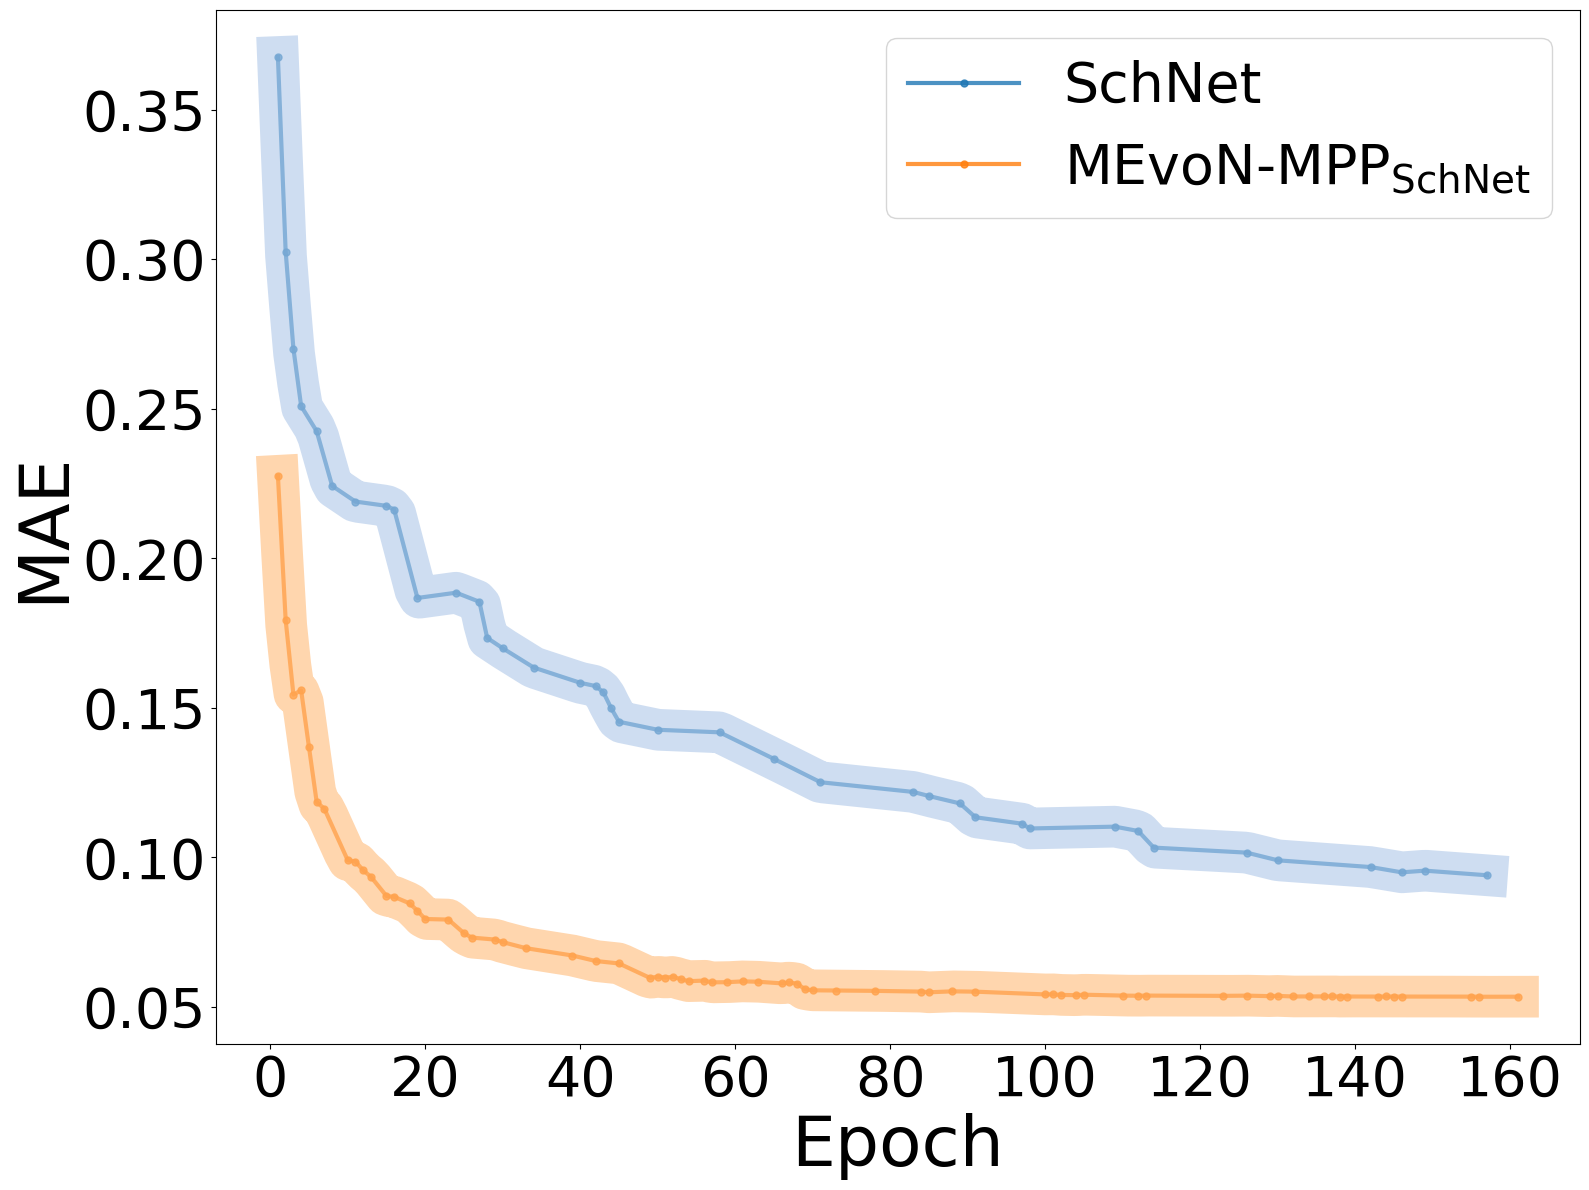

In [35]:
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# 定义解析日志文件的函数
def parse_log_file(file_path, output_num, start_line=2300):
    epochs = []
    mae_values = []
    current_epoch = None
    
    with open(file_path, 'r') as file:
        # 跳过前 start_line 行
        for _ in range(start_line):
            next(file)
        
        for line in file:
            # 匹配 epoch
            epoch_match = re.search(r'Epoch \[(\d+)/\d+\]', line)
            if epoch_match:
                current_epoch = int(epoch_match.group(1))
            
            # 匹配 MAE 值
            mae_match = re.search(rf'Output {output_num} - .* MAE: ([\d.]+)', line)
            if mae_match and current_epoch is not None:
                mae = float(mae_match.group(1))
                epochs.append(current_epoch)
                mae_values.append(mae)
    
    return epochs, mae_values

# 定义截断 epochs 和 mae 的函数
def truncate_epochs_and_mae(epochs, mae, max_epoch):
    truncated_epochs = []
    truncated_mae = []
    for epoch, value in zip(epochs, mae):
        if epoch <= max_epoch:
            truncated_epochs.append(epoch)
            truncated_mae.append(value)
    return truncated_epochs, truncated_mae

# 定义绘制曲线的函数
def plot_mae_curves(epochs1, mae1, epochs_best, mae_best, origin_name):
    # 确定最大 epoch 值
    max_epoch = min(max(epochs1), max(epochs_best), 300)
    
    # 截断 epochs 和 mae
    epochs1, mae1 = truncate_epochs_and_mae(epochs1, mae1, max_epoch)
    epochs_best, mae_best = truncate_epochs_and_mae(epochs_best, mae_best, max_epoch)
    
    # 调整图的大小
    plt.figure(figsize=(16, 12))
    
    # 绘制折线图
    plt.plot(epochs1, mae1, 'o-', color='#1f77b4', label=origin_name, markersize=5, linewidth=3, alpha=0.8)
    plt.plot(epochs_best, mae_best, 'o-', color='#ff7f0e', label=f'MEvoN-MPP$_{{\\mathrm{{{origin_name}}}}}$', markersize=5, linewidth=3, alpha=0.8)
    
    # 使用样条插值拟合曲线
    if len(epochs1) > 3:  # 确保有足够的数据点进行插值
        x_new1 = np.linspace(min(epochs1), max(epochs1), 300)
        spl1 = make_interp_spline(epochs1, mae1, k=1)
        y_new1 = spl1(x_new1)
        plt.plot(x_new1, y_new1, '-', color='#aec7e8', linewidth=30, alpha=0.6)
    
    if len(epochs_best) > 3:
        x_new_best = np.linspace(min(epochs_best), max(epochs_best), 300)
        spl_best = make_interp_spline(epochs_best, mae_best, k=1)
        y_new_best = spl_best(x_new_best)
        plt.plot(x_new_best, y_new_best, '-', color='#ffbb78', linewidth=30, alpha=0.6)
    
    # 设置坐标轴标签和字体大小
    plt.xlabel('Epoch', fontsize=50)
    plt.ylabel('MAE', fontsize=50)
    
    # 设置刻度字体大小
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    
    # 设置图例字体大小
    plt.legend(loc='upper right', fontsize=40)
    
    plt.grid(False)  # 关闭网格
    plt.tight_layout()  # 自动调整子图间距
    plt.show()

# 文件路径
file1 = '/home/data1/lk/project/mol_tree/logs/schnet/homo/only_schnet_qm9_homo_training_log_20250112_111521.log'
file2 = '/home/data1/lk/project/mol_tree/logs/schnet/homo/schnet_qm9_homo_training_log_20250111_170354.log'

# 解析日志文件
epochs1, mae1 = parse_log_file(file1, 1)
epochs2, mae2 = parse_log_file(file2, 2)
epochs3, mae3 = parse_log_file(file2, 3)

# 比较 mae2 和 mae3 的平均值，选择较优的
mae2_avg = np.mean(mae2) if mae2 else float('inf')
mae3_avg = np.mean(mae3) if mae3 else float('inf')

if mae2_avg < mae3_avg:
    print("选择的是 mae2")
    epochs_best, mae_best = epochs2, mae2
else:
    print("选择的是 mae3")
    epochs_best, mae_best = epochs3, mae3

# 提取 origin_name（夹在 only 和 qm9 之间的部分）
origin_name = file1.split('/')[-1].split('only_')[-1].split('_qm9')[0]
if origin_name == 'schnet':
    origin_name = 'SchNet'
elif origin_name == 'comenet':
    origin_name = 'ComENet'
elif origin_name == 'gin':
    origin_name = 'GIN'
elif origin_name == 'gcn':
    origin_name = 'GCN'
else:
    raise ValueError('Unknown origin name')

# 绘制MAE曲线
plot_mae_curves(epochs1, mae1, epochs_best, mae_best, origin_name)

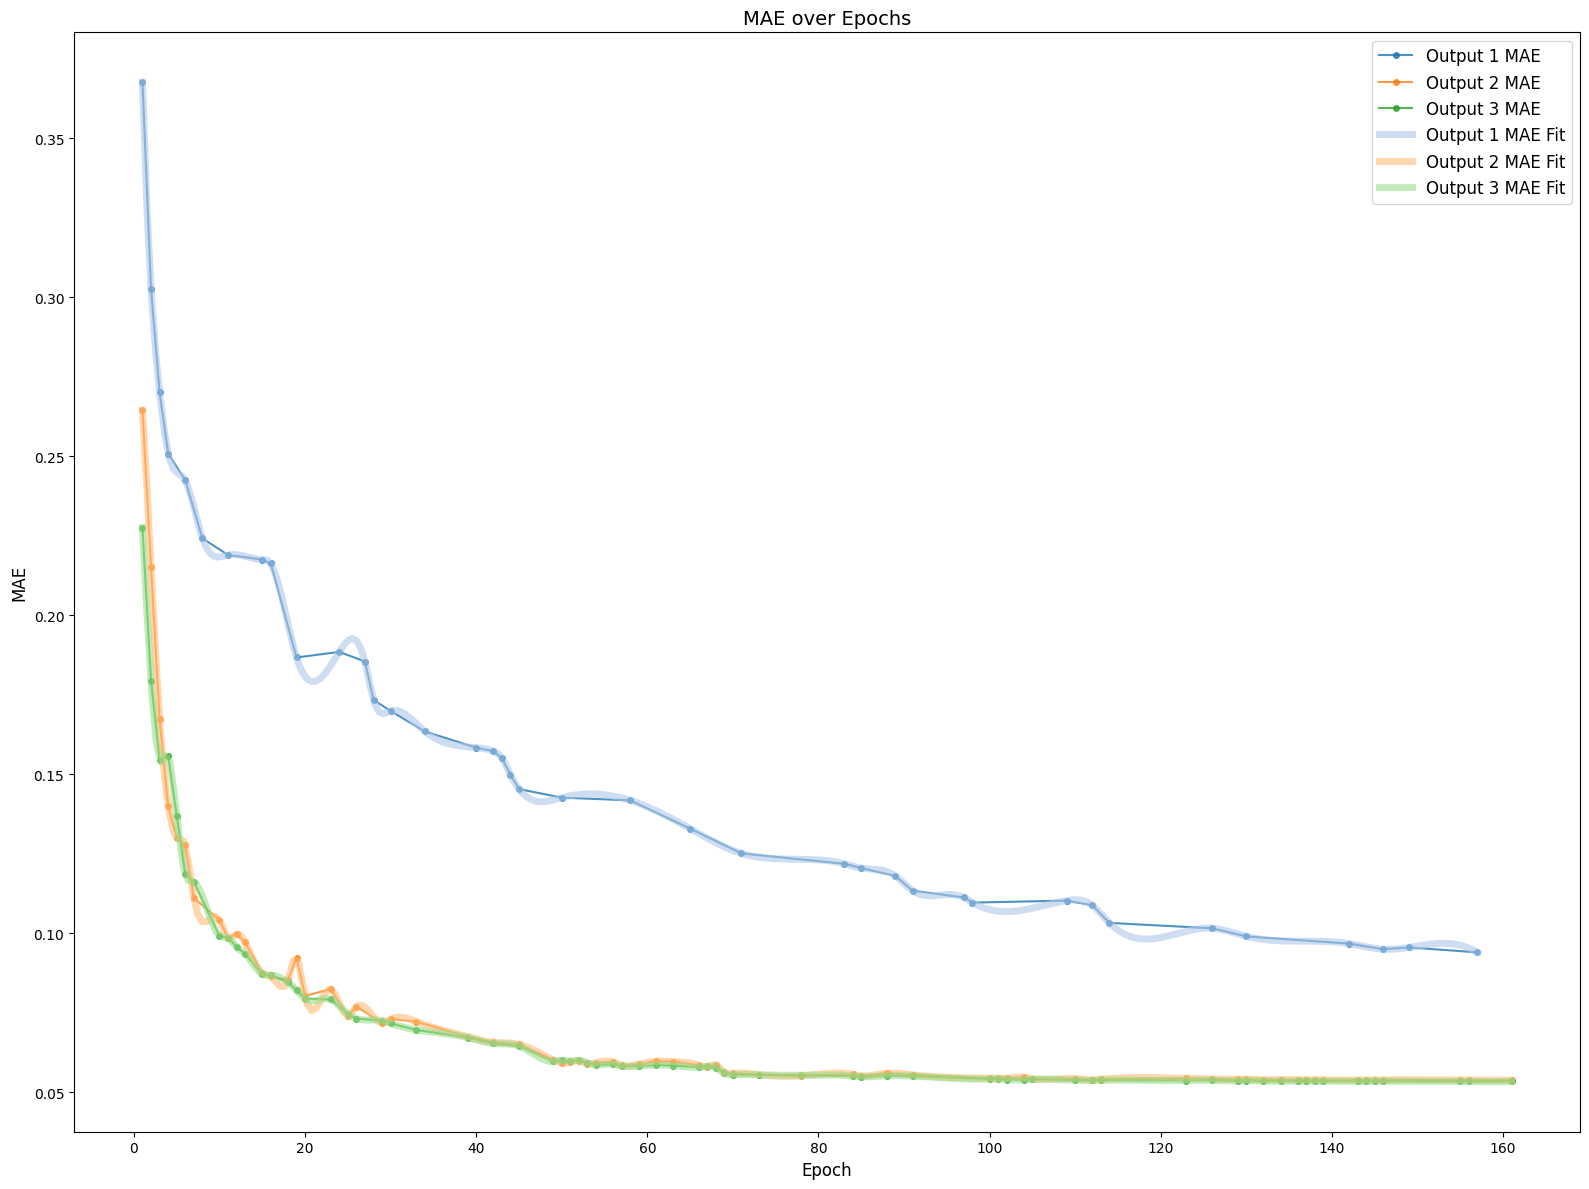

In [16]:
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# 定义解析日志文件的函数
def parse_log_file(file_path, output_num, start_line=2300):
    epochs = []
    mae_values = []
    current_epoch = None
    
    with open(file_path, 'r') as file:
        # 跳过前 start_line 行
        for _ in range(start_line):
            next(file)
        
        for line in file:
            # 匹配 epoch
            epoch_match = re.search(r'Epoch \[(\d+)/\d+\]', line)
            if epoch_match:
                current_epoch = int(epoch_match.group(1))
            
            # 匹配 MAE 值
            mae_match = re.search(rf'Output {output_num} - .* MAE: ([\d.]+)', line)
            if mae_match and current_epoch is not None:
                mae = float(mae_match.group(1))
                epochs.append(current_epoch)
                mae_values.append(mae)
    
    return epochs, mae_values

# 定义截断 epochs 和 mae 的函数
def truncate_epochs_and_mae(epochs, mae, max_epoch):
    truncated_epochs = []
    truncated_mae = []
    for epoch, value in zip(epochs, mae):
        if epoch <= max_epoch:
            truncated_epochs.append(epoch)
            truncated_mae.append(value)
    return truncated_epochs, truncated_mae

# 定义绘制曲线的函数
def plot_mae_curves(epochs1, mae1, epochs2, mae2, epochs3, mae3):
    # 确定最大 epoch 值
    max_epoch = min(max(epochs1), max(epochs2), max(epochs3), 300)
    
    # 截断 epochs 和 mae
    epochs1, mae1 = truncate_epochs_and_mae(epochs1, mae1, max_epoch)
    epochs2, mae2 = truncate_epochs_and_mae(epochs2, mae2, max_epoch)
    epochs3, mae3 = truncate_epochs_and_mae(epochs3, mae3, max_epoch)
    
    # 调整图的大小
    # plt.figure(figsize=(12, 8))
    plt.figure(figsize=(16, 12))
    
    # 绘制折线图
    plt.plot(epochs1, mae1, 'o-', color='#1f77b4', label='Output 1 MAE', markersize=4, linewidth=1.5, alpha=0.8)
    plt.plot(epochs2, mae2, 'o-', color='#ff7f0e', label='Output 2 MAE', markersize=4, linewidth=1.5, alpha=0.8)
    plt.plot(epochs3, mae3, 'o-', color='#2ca02c', label='Output 3 MAE', markersize=4, linewidth=1.5, alpha=0.8)
    
    # 使用样条插值拟合曲线
    if len(epochs1) > 3:  # 确保有足够的数据点进行插值
        x_new1 = np.linspace(min(epochs1), max(epochs1), 300)
        spl1 = make_interp_spline(epochs1, mae1, k=3)
        y_new1 = spl1(x_new1)
        plt.plot(x_new1, y_new1, '-', color='#aec7e8', label='Output 1 MAE Fit', linewidth=5, alpha=0.6)
    
    if len(epochs2) > 3:
        x_new2 = np.linspace(min(epochs2), max(epochs2), 300)
        spl2 = make_interp_spline(epochs2, mae2, k=3)
        y_new2 = spl2(x_new2)
        plt.plot(x_new2, y_new2, '-', color='#ffbb78', label='Output 2 MAE Fit', linewidth=5, alpha=0.6)
    
    if len(epochs3) > 3:
        x_new3 = np.linspace(min(epochs3), max(epochs3), 300)
        spl3 = make_interp_spline(epochs3, mae3, k=3)
        y_new3 = spl3(x_new3)
        plt.plot(x_new3, y_new3, '-', color='#98df8a', label='Output 3 MAE Fit', linewidth=5, alpha=0.6)
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('MAE', fontsize=12)
    plt.title('MAE over Epochs', fontsize=14)
    plt.legend(loc='upper right', fontsize=12, prop={'size': 12})  # 调整图例位置和字体大小
    plt.grid(False)  # 关闭网格
    plt.tight_layout()  # 自动调整子图间距
    plt.show()

# 文件路径
file1 = '/home/data1/lk/project/mol_tree/logs/schnet/homo/only_schnet_qm9_homo_training_log_20250112_111521.log'
file2 = '/home/data1/lk/project/mol_tree/logs/schnet/homo/schnet_qm9_homo_training_log_20250111_170354.log'

# 解析日志文件
epochs1, mae1 = parse_log_file(file1, 1)
epochs2, mae2 = parse_log_file(file2, 2)
epochs3, mae3 = parse_log_file(file2, 3)

# 绘制MAE曲线
plot_mae_curves(epochs1, mae1, epochs2, mae2, epochs3, mae3)

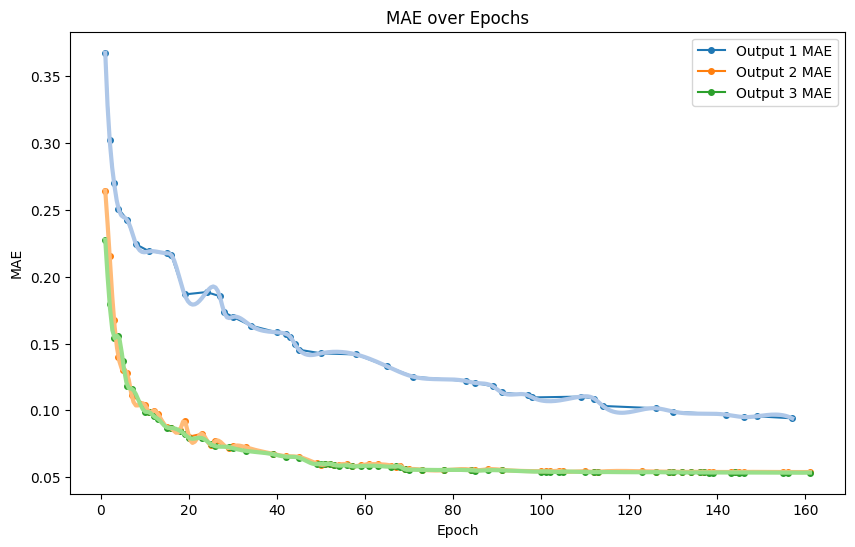

In [4]:
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# 定义解析日志文件的函数
def parse_log_file(file_path, output_num, start_line=2300):
    epochs = []
    mae_values = []
    current_epoch = None
    
    with open(file_path, 'r') as file:
        # 跳过前 start_line 行
        for _ in range(start_line):
            next(file)
        
        for line in file:
            # 匹配 epoch
            epoch_match = re.search(r'Epoch \[(\d+)/\d+\]', line)
            if epoch_match:
                current_epoch = int(epoch_match.group(1))
            
            # 匹配 MAE 值
            mae_match = re.search(rf'Output {output_num} - .* MAE: ([\d.]+)', line)
            if mae_match and current_epoch is not None:
                mae = float(mae_match.group(1))
                epochs.append(current_epoch)
                mae_values.append(mae)
    
    return epochs, mae_values

# 定义截断 epochs 和 mae 的函数
def truncate_epochs_and_mae(epochs, mae, max_epoch):
    truncated_epochs = []
    truncated_mae = []
    for epoch, value in zip(epochs, mae):
        if epoch <= max_epoch:
            truncated_epochs.append(epoch)
            truncated_mae.append(value)
    return truncated_epochs, truncated_mae

# 定义绘制曲线的函数
def plot_mae_curves(epochs1, mae1, epochs2, mae2, epochs3, mae3):
    # 确定最大 epoch 值
    max_epoch = min(max(epochs1), max(epochs2), max(epochs3), 300)
    
    # 截断 epochs 和 mae
    epochs1, mae1 = truncate_epochs_and_mae(epochs1, mae1, max_epoch)
    epochs2, mae2 = truncate_epochs_and_mae(epochs2, mae2, max_epoch)
    epochs3, mae3 = truncate_epochs_and_mae(epochs3, mae3, max_epoch)
    
    plt.figure(figsize=(10, 6))
    
    # 绘制折线图
    plt.plot(epochs1, mae1, 'o-', color='#1f77b4', label='Output 1 MAE', markersize=4)
    plt.plot(epochs2, mae2, 'o-', color='#ff7f0e', label='Output 2 MAE', markersize=4)
    plt.plot(epochs3, mae3, 'o-', color='#2ca02c', label='Output 3 MAE', markersize=4)
    
    # 使用样条插值拟合曲线
    if len(epochs1) > 3:  # 确保有足够的数据点进行插值
        x_new1 = np.linspace(min(epochs1), max(epochs1), 300)
        spl1 = make_interp_spline(epochs1, mae1, k=3)
        y_new1 = spl1(x_new1)
        plt.plot(x_new1, y_new1, '-', color='#aec7e8', linewidth=3)
    
    if len(epochs2) > 3:
        x_new2 = np.linspace(min(epochs2), max(epochs2), 300)
        spl2 = make_interp_spline(epochs2, mae2, k=3)
        y_new2 = spl2(x_new2)
        plt.plot(x_new2, y_new2, '-', color='#ffbb78', linewidth=3)
    
    if len(epochs3) > 3:
        x_new3 = np.linspace(min(epochs3), max(epochs3), 300)
        spl3 = make_interp_spline(epochs3, mae3, k=3)
        y_new3 = spl3(x_new3)
        plt.plot(x_new3, y_new3, '-', color='#98df8a', linewidth=3)
    
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('MAE over Epochs')
    plt.legend(loc='upper right')
    plt.grid(False)  # 关闭网格
    plt.show()

# 文件路径
file1 = '/home/data1/lk/project/mol_tree/logs/schnet/homo/only_schnet_qm9_homo_training_log_20250112_111521.log'
file2 = '/home/data1/lk/project/mol_tree/logs/schnet/homo/schnet_qm9_homo_training_log_20250111_170354.log'

# 解析日志文件
epochs1, mae1 = parse_log_file(file1, 1)
epochs2, mae2 = parse_log_file(file2, 2)
epochs3, mae3 = parse_log_file(file2, 3)

# 绘制MAE曲线
plot_mae_curves(epochs1, mae1, epochs2, mae2, epochs3, mae3)

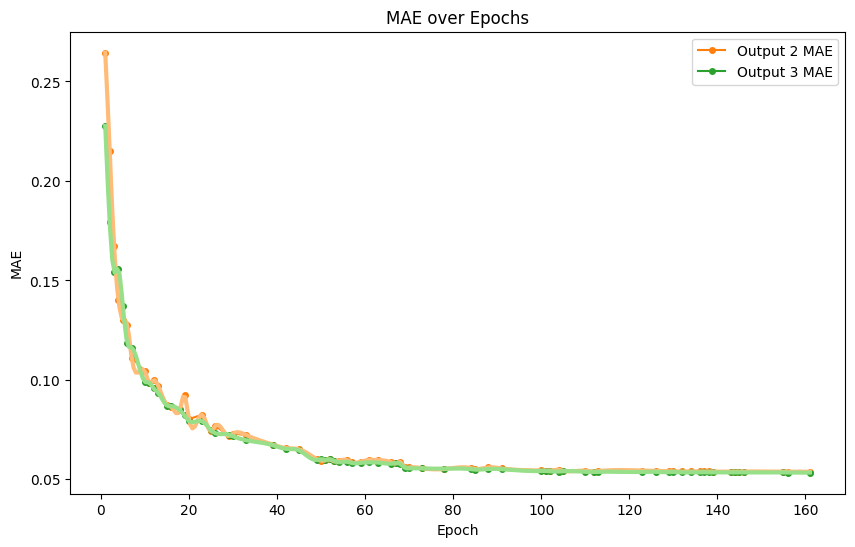

In [6]:
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# 定义解析日志文件的函数
def parse_log_file(file_path, output_num, start_line=2300):
    epochs = []
    mae_values = []
    current_epoch = None
    
    with open(file_path, 'r') as file:
        # 跳过前 start_line 行
        for _ in range(start_line):
            next(file)
        
        for line in file:
            # 匹配 epoch
            epoch_match = re.search(r'Epoch \[(\d+)/\d+\]', line)
            if epoch_match:
                current_epoch = int(epoch_match.group(1))
            
            # 匹配 MAE 值
            mae_match = re.search(rf'Output {output_num} - .* MAE: ([\d.]+)', line)
            if mae_match and current_epoch is not None:
                mae = float(mae_match.group(1))
                epochs.append(current_epoch)
                mae_values.append(mae)
    
    return epochs, mae_values

# 定义截断 epochs 和 mae 的函数
def truncate_epochs_and_mae(epochs, mae, max_epoch):
    truncated_epochs = []
    truncated_mae = []
    for epoch, value in zip(epochs, mae):
        if epoch <= max_epoch:
            truncated_epochs.append(epoch)
            truncated_mae.append(value)
    return truncated_epochs, truncated_mae

# 定义绘制曲线的函数（只绘制 Output 2 和 Output 3）
def plot_mae_curves(epochs2, mae2, epochs3, mae3):
    # 确定最大 epoch 值
    max_epoch = min(max(epochs2), max(epochs3), 300)
    
    # 截断 epochs 和 mae
    epochs2, mae2 = truncate_epochs_and_mae(epochs2, mae2, max_epoch)
    epochs3, mae3 = truncate_epochs_and_mae(epochs3, mae3, max_epoch)
    
    plt.figure(figsize=(10, 6))
    
    # 绘制折线图（只绘制 Output 2 和 Output 3）
    plt.plot(epochs2, mae2, 'o-', color='#ff7f0e', label='Output 2 MAE', markersize=4)
    plt.plot(epochs3, mae3, 'o-', color='#2ca02c', label='Output 3 MAE', markersize=4)
    
    # 使用样条插值拟合曲线
    if len(epochs2) > 3:  # 确保有足够的数据点进行插值
        x_new2 = np.linspace(min(epochs2), max(epochs2), 300)
        spl2 = make_interp_spline(epochs2, mae2, k=3)
        y_new2 = spl2(x_new2)
        plt.plot(x_new2, y_new2, '-', color='#ffbb78', linewidth=3)
    
    if len(epochs3) > 3:
        x_new3 = np.linspace(min(epochs3), max(epochs3), 300)
        spl3 = make_interp_spline(epochs3, mae3, k=3)
        y_new3 = spl3(x_new3)
        plt.plot(x_new3, y_new3, '-', color='#98df8a', linewidth=3)
    
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('MAE over Epochs')
    plt.legend(loc='upper right')
    plt.grid(False)  # 关闭网格
    plt.show()

# 文件路径
file1 = '/home/data1/lk/project/mol_tree/logs/schnet/homo/only_schnet_qm9_homo_training_log_20250112_111521.log'
file2 = '/home/data1/lk/project/mol_tree/logs/schnet/homo/schnet_qm9_homo_training_log_20250111_170354.log'

# 解析日志文件（只解析 Output 2 和 Output 3）
epochs2, mae2 = parse_log_file(file2, 2)
epochs3, mae3 = parse_log_file(file2, 3)

# 绘制MAE曲线（只绘制 Output 2 和 Output 3）
plot_mae_curves(epochs2, mae2, epochs3, mae3)

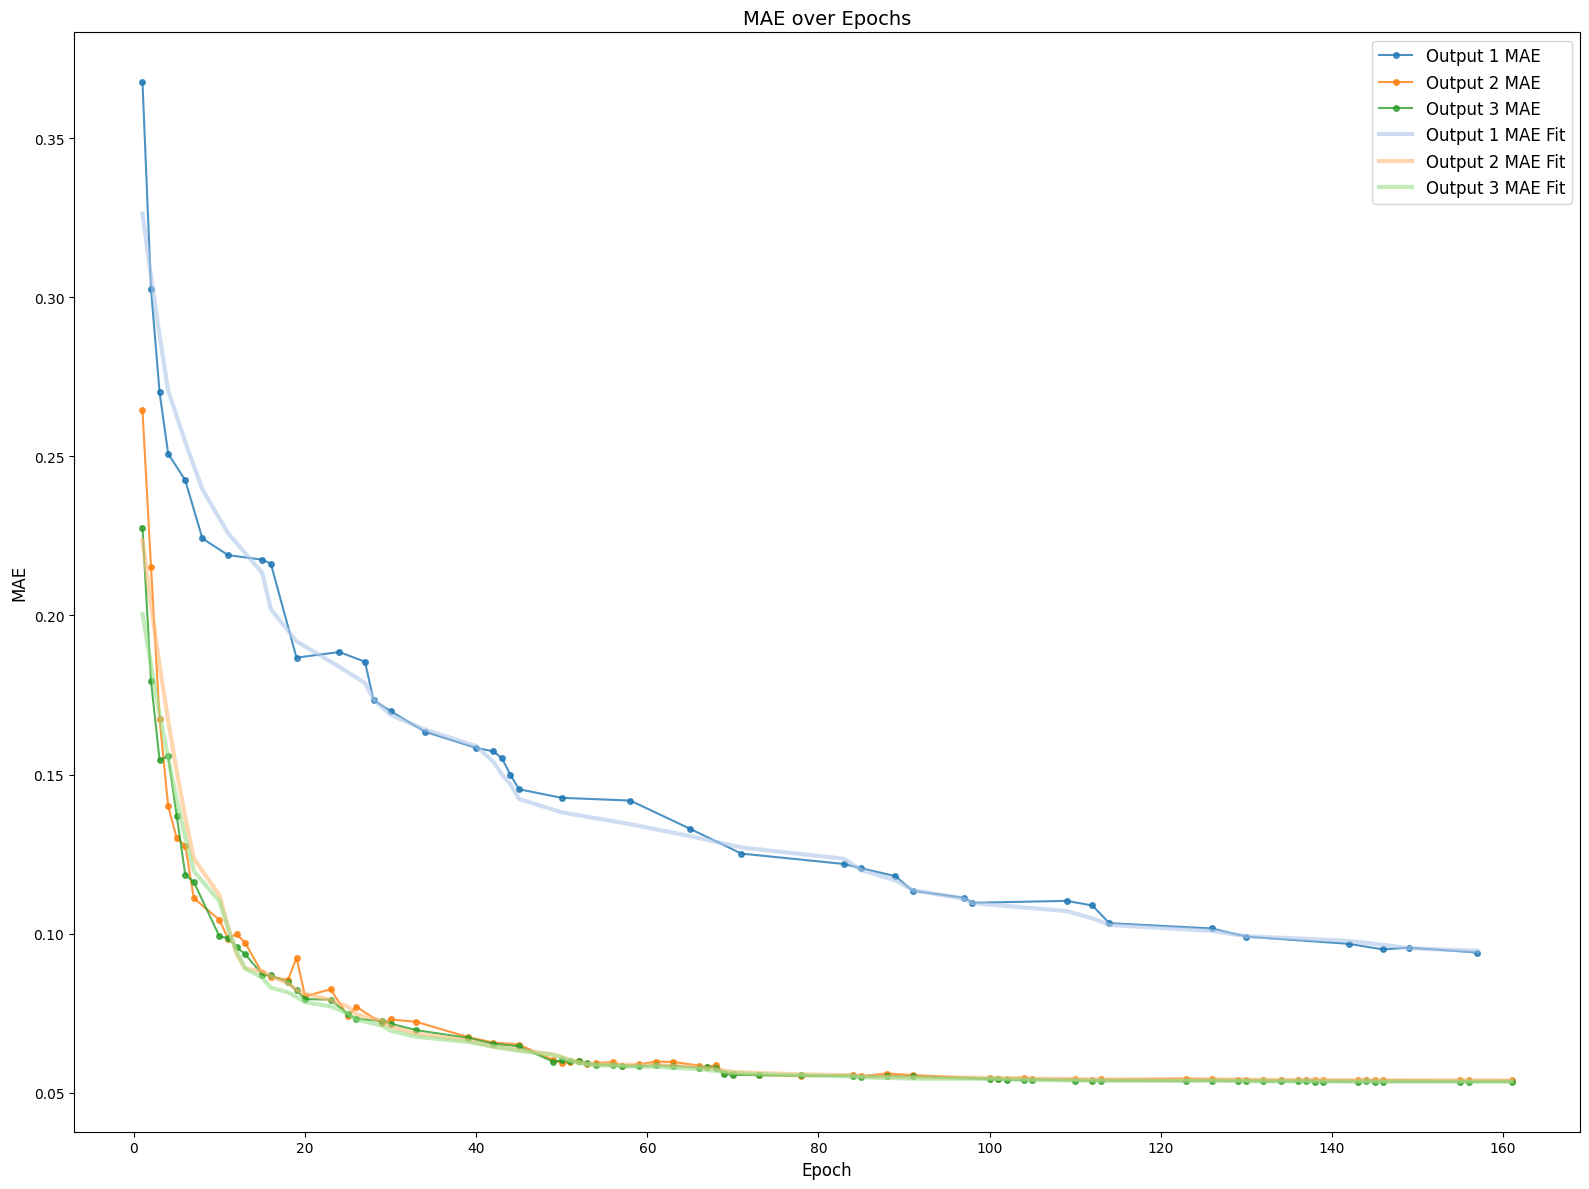

In [13]:
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter

# 定义解析日志文件的函数
def parse_log_file(file_path, output_num, start_line=2300):
    epochs = []
    mae_values = []
    current_epoch = None
    
    with open(file_path, 'r') as file:
        # 跳过前 start_line 行
        for _ in range(start_line):
            next(file)
        
        for line in file:
            # 匹配 epoch
            epoch_match = re.search(r'Epoch \[(\d+)/\d+\]', line)
            if epoch_match:
                current_epoch = int(epoch_match.group(1))
            
            # 匹配 MAE 值
            mae_match = re.search(rf'Output {output_num} - .* MAE: ([\d.]+)', line)
            if mae_match and current_epoch is not None:
                mae = float(mae_match.group(1))
                epochs.append(current_epoch)
                mae_values.append(mae)
    
    return epochs, mae_values

# 定义截断 epochs 和 mae 的函数
def truncate_epochs_and_mae(epochs, mae, max_epoch):
    truncated_epochs = []
    truncated_mae = []
    for epoch, value in zip(epochs, mae):
        if epoch <= max_epoch:
            truncated_epochs.append(epoch)
            truncated_mae.append(value)
    return truncated_epochs, truncated_mae

# 定义绘制曲线的函数
def plot_mae_curves(epochs1, mae1, epochs2, mae2, epochs3, mae3):
    # 确定最大 epoch 值
    max_epoch = min(max(epochs1), max(epochs2), max(epochs3), 300)
    
    # 截断 epochs 和 mae
    epochs1, mae1 = truncate_epochs_and_mae(epochs1, mae1, max_epoch)
    epochs2, mae2 = truncate_epochs_and_mae(epochs2, mae2, max_epoch)
    epochs3, mae3 = truncate_epochs_and_mae(epochs3, mae3, max_epoch)
    
    # 调整图的大小
    plt.figure(figsize=(16, 12))
    
    # 绘制折线图
    plt.plot(epochs1, mae1, 'o-', color='#1f77b4', label='Output 1 MAE', markersize=4, linewidth=1.5, alpha=0.8)
    plt.plot(epochs2, mae2, 'o-', color='#ff7f0e', label='Output 2 MAE', markersize=4, linewidth=1.5, alpha=0.8)
    plt.plot(epochs3, mae3, 'o-', color='#2ca02c', label='Output 3 MAE', markersize=4, linewidth=1.5, alpha=0.8)
    
    # 使用 Savitzky-Golay 滤波器平滑数据
    if len(epochs1) > 5:  # 确保有足够的数据点进行平滑
        window_length = min(len(epochs1), 20)  # 窗口长度（奇数）
        polyorder = 2  # 多项式阶数
        smoothed_mae1 = savgol_filter(mae1, window_length, polyorder)
        plt.plot(epochs1, smoothed_mae1, '-', color='#aec7e8', label='Output 1 MAE Fit', linewidth=3, alpha=0.6)
    
    if len(epochs2) > 5:
        window_length = min(len(epochs2), 20)
        smoothed_mae2 = savgol_filter(mae2, window_length, polyorder)
        plt.plot(epochs2, smoothed_mae2, '-', color='#ffbb78', label='Output 2 MAE Fit', linewidth=3, alpha=0.6)
    
    if len(epochs3) > 5:
        window_length = min(len(epochs3), 20)
        smoothed_mae3 = savgol_filter(mae3, window_length, polyorder)
        plt.plot(epochs3, smoothed_mae3, '-', color='#98df8a', label='Output 3 MAE Fit', linewidth=3, alpha=0.6)
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('MAE', fontsize=12)
    plt.title('MAE over Epochs', fontsize=14)
    
    # 调整图例的大小
    plt.legend(loc='upper right', fontsize=12, prop={'size': 12})  # 调整图例字体大小
    
    plt.grid(False)  # 关闭网格
    plt.tight_layout()  # 自动调整子图间距
    plt.show()

# 文件路径
file1 = '/home/data1/lk/project/mol_tree/logs/schnet/homo/only_schnet_qm9_homo_training_log_20250112_111521.log'
file2 = '/home/data1/lk/project/mol_tree/logs/schnet/homo/schnet_qm9_homo_training_log_20250111_170354.log'

# 解析日志文件
epochs1, mae1 = parse_log_file(file1, 1)
epochs2, mae2 = parse_log_file(file2, 2)
epochs3, mae3 = parse_log_file(file2, 3)

# 绘制MAE曲线
plot_mae_curves(epochs1, mae1, epochs2, mae2, epochs3, mae3)